<a href="https://colab.research.google.com/github/Griffin-Jordan/StormStocks/blob/main/Reddit_Sentiment_Forecast2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/DS440/unique_data.csv'

In [5]:
# Now, read the CSV file
df = pd.read_csv(file_path)


In [6]:
df = pd.DataFrame(df)

# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

df['Title_Sentiment'] = df['Title'].astype(str).apply(lambda title: sia.polarity_scores(title)['compound'])

# Convert 'Comments' to strings as well, to avoid TypeError with non-string types
df['Comments_Sentiment'] = df['Comments'].astype(str).apply(lambda comments: sia.polarity_scores(comments)['compound'])
# Display the updated DataFrame

In [50]:
average_scores = df.groupby('ticker')[['Title_Sentiment', 'Comments_Sentiment']].mean().reset_index()

# Display the resulting DataFrame
print(average_scores)

   ticker  Title_Sentiment  Comments_Sentiment
0    AAPL         0.029044            0.189131
1    AMGN         0.199160           -0.081920
2     AXP         0.145717            0.230817
3      BA         0.140808            0.090008
4     CAT        -0.001673            0.034355
5     CRM         0.052743            0.121829
6    CSCO        -0.036733            0.225867
7     CVX         0.211986           -0.046371
8     DIS         0.085600            0.192279
9     DOW        -0.121650           -0.007610
10     GS        -0.082846            0.021669
11     HD         0.083845            0.051827
12    HON        -0.007150            0.050450
13    IBM        -0.039478            0.145100
14   INTC         0.034281            0.303488
15    JNJ        -0.050455            0.269373
16    JPM         0.010645            0.201682
17     KO         0.080985            0.179577
18    MCD        -0.070788            0.277087
19    MMM         0.203560           -0.072250
20    MRK    

In [54]:
# Normalize the average sentiment scores
average_scores['Average_Sentiment'] = average_scores[['Title_Sentiment', 'Comments_Sentiment']].mean(axis=1)
average_scores["norm_score"] = average_scores['Average_Sentiment'] - average_scores['Average_Sentiment'].min()
average_scores["norm_score"] /= average_scores["norm_score"].max()

In [55]:
import yfinance as yf
import pandas as pd
yf.pdr_override()

# Define the ticker and the start date
ticker = "BA"
start_date = "2023-1-1"
stock = yf.Ticker(ticker)
data = stock.history(start=start_date)

# Create a DataFrame to hold the 'Adj Close' values
data = pd.DataFrame(data['Close'], columns=['Close'])

# Display the first few rows to verify
print(data.tail())

                                Close
Date                                 
2024-04-03 00:00:00-04:00  184.919998
2024-04-04 00:00:00-04:00  183.289993
2024-04-05 00:00:00-04:00  183.139999
2024-04-08 00:00:00-04:00  181.559998
2024-04-09 00:00:00-04:00  177.509995


In [60]:
# ticker = "AAPL"
# data = pd.DataFrame()
# data[ticker] = pdr.DataReader(ticker, data_source= yf, start="2023-1-1")['Adj Close']

In [56]:
log_returns = np.log(1 + data.pct_change())
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5 * var)
stdev = log_returns.std()
np.array(drift)
x = np.random.rand(10,2)
Z = norm.ppf(np.random.rand(10,2))
t_intervals = 60
iterations = 10
daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))
S0 = data.iloc[-1]
price_list = np.zeros_like(daily_returns)
price_list[0] = S0
for t in range(1, t_intervals):
  price_list[t] = price_list[t - 1] * daily_returns[t]

In [57]:
sentiment_weight = average_scores.loc[average_scores['ticker'] == ticker, 'norm_score'].iloc[0]


# Adjust drift and standard deviation according to the sentiment weight
# This is a simple example; the exact formula should be based on your investment model
adjusted_drift = drift.values * sentiment_weight
adjusted_stdev = stdev.values * np.sqrt(sentiment_weight)  # This is an assumption; adjust as needed

# Calculate daily returns using the adjusted drift and volatility
daily_returns = np.exp(adjusted_drift + adjusted_stdev * norm.ppf(np.random.rand(t_intervals, iterations)))

# Assuming S0 is the last adjusted close price
S0 = data.iloc[-1]
price_list = np.zeros_like(daily_returns)
price_list[0] = S0

# Generate the price list for each day
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]
average_price_path = price_list.mean(axis=1)

In [58]:
actual_data = data[-120:]

# Last date from actual data
last_actual_date = actual_data.index[-1]

# Generate forecast dates starting from the day after the last actual date
forecast_dates = pd.date_range(start=last_actual_date + pd.Timedelta(days=1), periods=60)

# Assuming `forecasted_prices` is your 60-day forecast
forecasted_prices = average_price_path

forecast_series = pd.Series(forecasted_prices, index=forecast_dates)

full_series = pd.concat([actual_data, forecast_series])

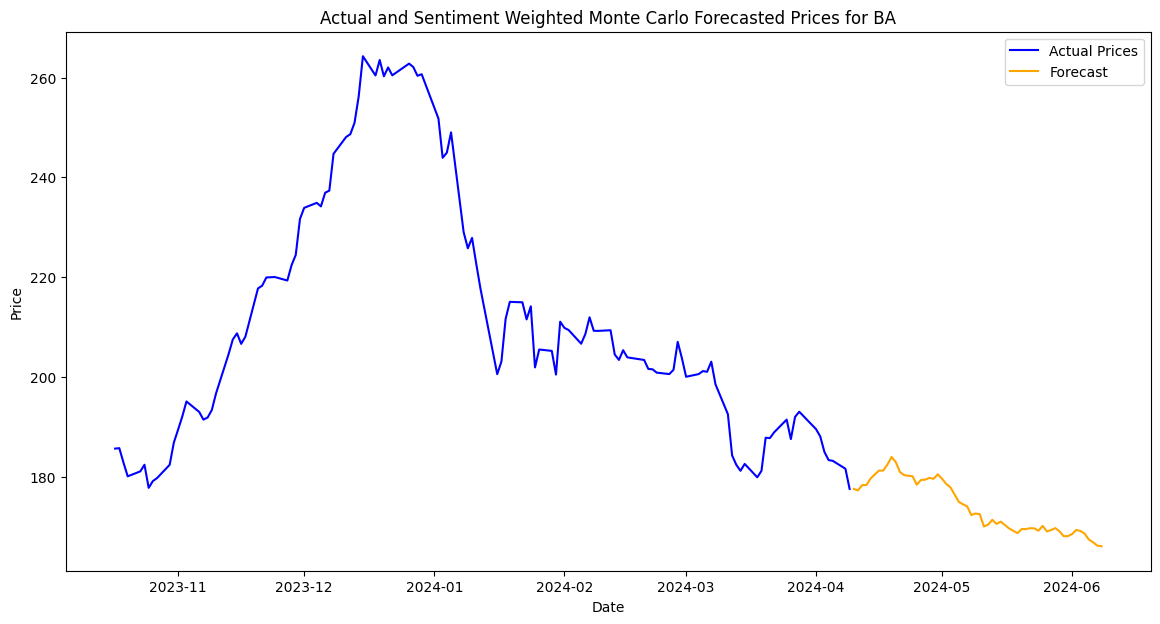

In [59]:
plt.figure(figsize=(14, 7))

# Plot the actual data
plt.plot(actual_data.index, actual_data, color='blue', label='Actual Prices')

# Highlight the forecast period in a different color
plt.plot(forecast_series.index, forecast_series, color='orange', label='Forecast')

# Add labels, title, and legend
plt.title(f"Actual and Sentiment Weighted Monte Carlo Forecasted Prices for {ticker}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Show the plot
plt.show()